## Evaluation on the test data

In [1]:
# To import functions from utils.py, which is in the parent diretory

import sys
import os

current_dir = os.path.dirname(os.path.abspath('__file__')) 

parent_dir = os.path.dirname(current_dir)

sys.path.append(parent_dir)

In [2]:
import pandas as pd
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from collections import defaultdict
from sklearn.model_selection import GroupKFold
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb
import lightgbm as lgb
import warnings
from utils import create_all_features
warnings.filterwarnings("ignore")

sns.set_style("whitegrid")

### Load Data

In [3]:
train = pd.read_csv("../2. Train Test Split/training_data.csv")
test = pd.read_csv("../2. Train Test Split/test_data.csv")
updrs_cols = ['updrs_1', 'updrs_2', 'updrs_3']
clinical_feature_time_dependent = ['sbr_caudate_r', 'sbr_caudate_l', 'sbr_putamen_r', 'sbr_putamen_l']

### Transform test data using training-derived preprocessing and feature engineering

To ensure compatibility between the training and test sets, we collect all preprocessing and feature engineering steps into the `create_and_modify_all_features` function in `utils.py`. To prevent data leakage, decisions such as grouping rare categories are learned from the training set and then applied to the test set.

In [4]:
print("Creating features for training data...")
train_featured_df, learned_dummy_map, initial_feature_cols = create_all_features(train, updrs_cols, clinical_feature_time_dependent)

print("Creating features for test data...")
test_featured_df = create_all_features(test, updrs_cols, clinical_feature_time_dependent, dummy_map = learned_dummy_map)[0]

Creating features for training data...
Adding change rate features...
Adding rolling average features...
Adding volatility features...
Adding time-adjusted features...
Adding UPDRS ratio features...
Creating features for test data...
Adding change rate features...
Adding rolling average features...
Adding volatility features...
Adding time-adjusted features...
Adding UPDRS ratio features...


### Align Columns (Crucial for Dummies)
Ensure both dataframes have the exact same columns after dummy creation, since some categories might exist in train but not test, or vice-versa.

In [5]:
train_cols = set(train_featured_df.columns)
test_cols = set(test_featured_df.columns)

missing_in_test = list(train_cols - test_cols)
missing_in_train = list(test_cols - train_cols)

# Add missing columns to the test set and fill with 0
for col in missing_in_test:
    if col not in updrs_cols:
      test_featured_df[col] = 0
for col in missing_in_train:
    if col not in updrs_cols:
      train_featured_df[col] = 0

# Ensure the order is the same
test_featured_df = test_featured_df[train_featured_df.columns]


print("\nFeature engineering complete. Training and test sets now have the same structure.")


Feature engineering complete. Training and test sets now have the same structure.


### Collecting the feature columns

In [6]:
cols_for_ts = updrs_cols + clinical_feature_time_dependent

static_clinical_features = initial_feature_cols + [i for i in train_featured_df.columns if ("Eigenvalue" in i) or ("Fractional Anisotropy" in i)]

lagged_feature_cols = [col for col in train_featured_df.columns if '_lag_' in col]

trend_feature_cols = [col for col in train_featured_df.columns if any(x in col for x in ['slope', 'mean', 'weighted', 'std', 'range', 'adj', 'ratio', 'trend'])]

final_feature_cols = static_clinical_features + lagged_feature_cols + trend_feature_cols + ["age_x_visit_month"]

# avoid duplicated elements arising from both lagged_feature_cols and trend_feature_cols
final_feature_cols = list(dict.fromkeys(final_feature_cols))


### Train and test the pipeline obtained from hyperparameter tuning

In [ ]:
X_train, y_train = train_featured_df[final_feature_cols], train_featured_df[updrs_cols]

X_test, y_test = test_featured_df[final_feature_cols], test_featured_df[updrs_cols]

mae_results_best_model = defaultdict(list)

best_model_pipeline = joblib.load("../5. model construction, feature engineering and model tuning/lgbm_model.pkl")

best_model_pipeline.fit(X_train, y_train)

predictions_array = best_model_pipeline.predict(X_test)

predictions_df = pd.DataFrame(predictions_array, index=y_test.index, columns=updrs_cols)

for col in updrs_cols:
    actual_values = y_test[col]
    predicted_values = predictions_df[col]
    
    mae = mean_absolute_error(actual_values, predicted_values)
    mae_results_best_model[col].append(mae)

print("\n--- Final Test Results ---")
for col, scores in mae_results_best_model.items():
    avg_mae = np.mean(scores)
    print(f"Average MAE for {col}: {avg_mae:.4f}")




--- Final Test Results ---
Average MAE for updrs_1: 2.5631
Average MAE for updrs_2: 2.4625
Average MAE for updrs_3: 5.5675


### Compare with the strongest baseline

In [8]:
mae_results_baseline = {}

mean_by_month = train_featured_df.groupby('visit_month')[updrs_cols].mean()

global_mean_preds = train_featured_df[updrs_cols].mean().to_dict()

test_preds_mean = test_featured_df.copy()

test_preds_month_mean = test_preds_mean.merge(
    mean_by_month.rename(columns=lambda c: f'pred_{c}'),
    on='visit_month',
    how='left'
)

for col in updrs_cols:
    test_preds_month_mean[f'pred_{col}']=test_preds_month_mean[f'pred_{col}'].fillna(global_mean_preds[col])

for col in updrs_cols:
    actual_values = test_preds_month_mean[col]
    predicted_values = test_preds_month_mean[f'pred_{col}']

    valid_indices = predicted_values.notna()
    mae = mean_absolute_error(actual_values[valid_indices], predicted_values[valid_indices])
    mae_results_baseline[col]=mae


print("\n")
for col, score in mae_results_baseline.items():
    print(f"Average MAE for {col}: {score:.4f}")




Average MAE for updrs_1: 4.2170
Average MAE for updrs_2: 5.1864
Average MAE for updrs_3: 11.5018


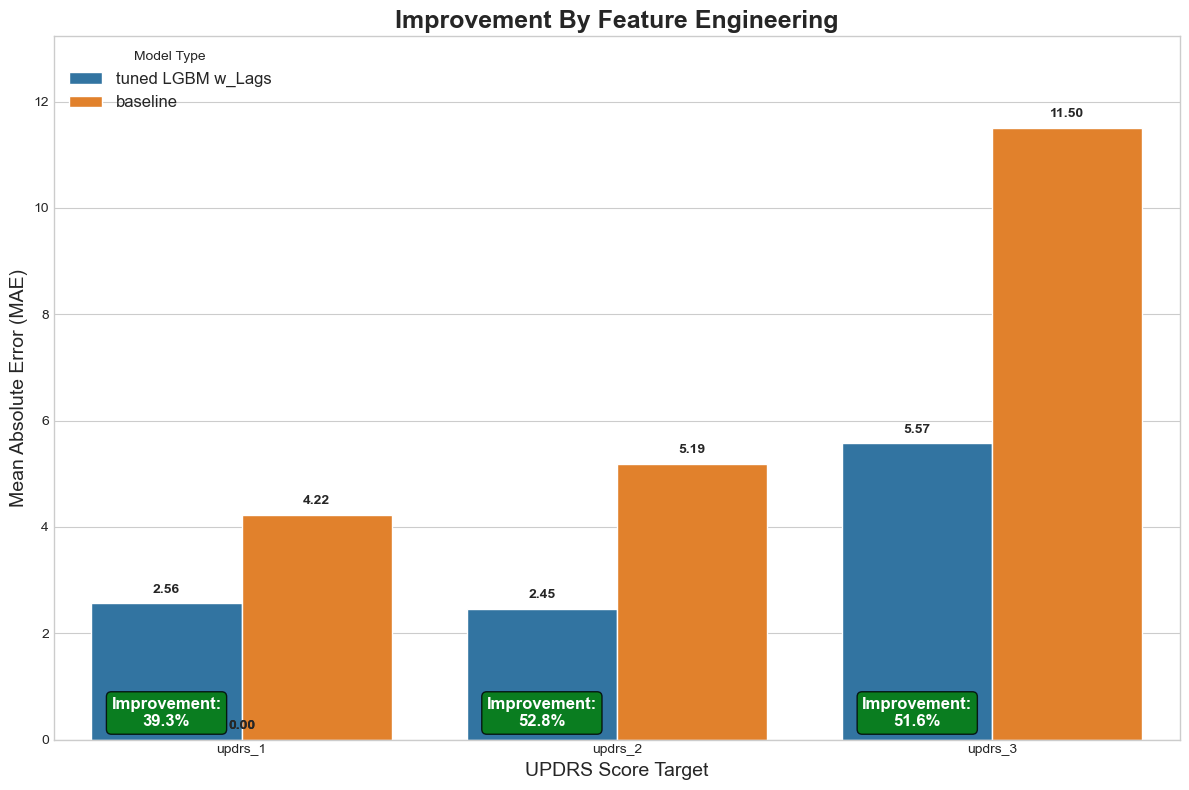

In [ ]:
mae_bs_averages = {col: np.mean(np.array([mae_results_baseline[col]])) for col in mae_results_baseline}

baseline_metric = pd.DataFrame([mae_bs_averages])

baseline_metric["model"] = "baseline"

mae_final_averages = {col: np.mean(np.array([mae_results_best_model[col]])) for col in mae_results_best_model}

final_metric = pd.DataFrame([mae_final_averages])

final_metric["model"] = "tuned LGBM w_Lags"

mae_comparison = pd.concat([final_metric, baseline_metric], ignore_index = True)

df = mae_comparison.melt(id_vars='model', var_name='target', value_name='error').dropna()

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))

sns.barplot(data=df, x='target', y='error', hue='model', ax=ax)
for p in ax.patches:
    ax.annotate(
        f'{p.get_height():.2f}',          
        (p.get_x() + p.get_width() / 2., p.get_height()), 
        ha='center',                       
        va='center',                       
        xytext=(0, 10),                 
        textcoords='offset points',
        fontweight='bold'
    )

ax.set_title('Model Performance Improvement: Baseline vs. Final LGBM Model', fontsize=18, fontweight='bold')
ax.set_ylabel('Mean Absolute Error (MAE)', fontsize=14)
ax.set_xlabel('UPDRS Score Target', fontsize=14)
ax.legend(title='Model Type', fontsize=12)
ax.set_ylim(0, df['error'].max() * 1.15)

baseline_maes = df[df['model'] == 'baseline']['error'].values
final_maes = df[df['model'] == 'tuned LGBM w_Lags']['error'].values
improvements = ((baseline_maes - final_maes) / baseline_maes) * 100

x_coords = [p.get_x() + p.get_width() / 2. for p in ax.patches[:3]]

for i, improvement in enumerate(improvements):
    ax.annotate(
        f'Improvement:\n{improvement:.1f}%',
        xy=(x_coords[i], 0.5), # Place it low on the plot for clarity
        ha='center',
        va='center',
        color='white',
        fontweight='bold',
        fontsize=12,
        bbox=dict(boxstyle="round,pad=0.3", fc="green", ec="black", lw=1, alpha=0.8)
    )

# --- 4. Final Touches ---
ax.set_title('Improvement By Feature Engineering', fontsize=18, fontweight='bold')
ax.set_ylabel('Mean Absolute Error (MAE)', fontsize=14)
ax.set_xlabel('UPDRS Score Target', fontsize=14)
ax.legend(title='Model Type', fontsize=12)
ax.set_ylim(0, df['error'].max() * 1.15)


plt.tight_layout()
plt.show()

### Observation: 
All the final mean absolute errors, falls in one standard deviation of the mean absolute errors we get during the hyperparameter tuning.


### Analysis
Our model avoided overfitting and learned some meaningful pattern in the dataset.

### Export the final pipeline

In [16]:
joblib.dump(best_model_pipeline, 'final_lgbm_model.pkl')

['final_lgbm_model.pkl']